# Methanol Spray Flame Combustion

![A black-and-white diagram showing the experimental setup used to make measurments of the Methanol Sray Flame](experimental-setup.png)

For my final project of the year I found yet another dataset published on a government website. This one is similar to the NASA dataset I did earlier because it combines spatial data with measured physical values.

The [dataset](https://webbook.nist.gov/chemistry/special/spray-combust/) comes from an experiment whose goal was to create some data to validate computer models of methanol spray flames. I focused on one data table from the study.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn

## The data

In [2]:
df = pd.read_csv("data-a4.csv"); df.head() # Print the first five rows

,radius,v-radial,v-axial,v-tangential,v-magnitude
0,19.580,0.15269,1.5642,1.2584,2.0134
1,20.426,0.20795,1.7472,1.4606,2.2868
2,21.272,0.23386,1.9494,1.7133,2.6058
3,22.118,0.24077,2.1535,2.0008,2.9494
4,22.964,0.23195,2.3530,2.3544,3.3367


The variables are pretty easy to understand:

- `radius`: the exit radius of the burner (independent variable)
- `v-radial`, `v-axial`, `v-tangential`: three components of velocity
- `v-magnitude`: magnitude of velocity: $\sqrt{\text{v-radial}^2 + \text{v-axial}^2 + \text{v-tangential}^2}$

I thought it would be interesting to predict individual components of velocity based on `radius` and `v-magnitude`. `v-magnitude` is a mathematical combination of `v-radial`, `v-axial`, and `v-tangential`, but the operation can't be reversed without knowing two of the values. I want to create a model that can predict individual components of velocity based on just burner radius and the velocity magnitude.

<Axes: ylabel='Frequency'>

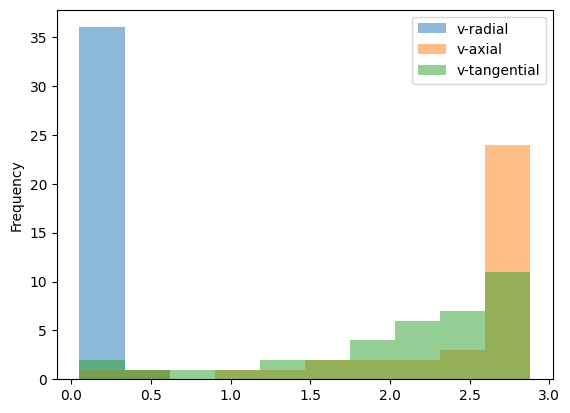

In [3]:
# Plot histograms for the three outputs.
df.plot.hist(column=["v-radial", "v-axial", "v-tangential"], bins=10, alpha=0.5)

This graph is a histogram of the output data. The good news is that there are no strange trends (it's just single-modal with skew), so if I were doing a model from earlier in the year, it would have probably worked as well.

<Axes: xlabel='radius'>

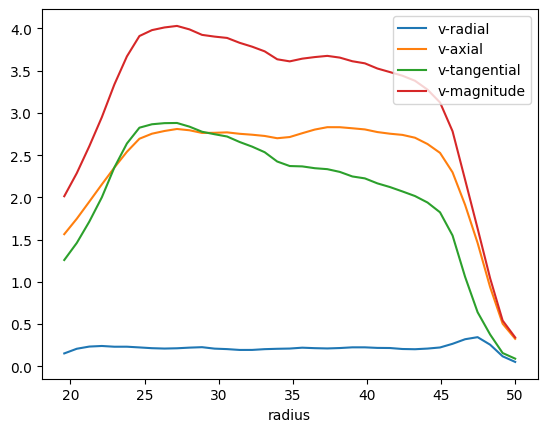

In [4]:
# Plot the actual data of the three outputs
df.plot(x="radius", y=["v-radial", "v-axial", "v-tangential", "v-magnitude"])

This is a graph of the three output values and `v-magnitude` by radius. It shows that `v-magnitude` is a combination of velocities, and that the velocities themselves have individual trends that need to be represented.

## Tensors

The next step was to convert the data into a format that torch can understand.

In [5]:
# Convert all our data to tensors
radius       = torch.from_numpy(df["radius"].to_numpy())
v_radial     = torch.from_numpy(df["v-radial"].to_numpy())
v_axial      = torch.from_numpy(df["v-axial"].to_numpy())
v_tangential = torch.from_numpy(df["v-tangential"].to_numpy())
v_magnitude  = torch.from_numpy(df["v-magnitude"].to_numpy())

Each of the five values is essentially just a $1 \times n$ matrix, where $n$ is the number of rows in the original dataset:

\begin{align*}
\text{radius} &= [19.5800, 20.4260, 21.2720, \cdots] \\
\text{v\_radial} &= [0.1527, 0.2079, 0.2339, \cdots] \\
\text{v\_axial} &= [1.5642, 1.7472, 1.9494, \cdots] \\
\text{v\_tangential} &= [1.2584, 1.4606, 1.7133, \cdots] \\
\text{v\_magnitude} &= [2.0134, 2.2868, 2.6058, \cdots]
\end{align*}

Next, we have to combine the input values into one matrix and output values into another:

In [6]:
# Radius and magnitude are input values, so we reorient them and combine them into an input matrix
X = torch.cat((radius.unsqueeze(dim=1), v_magnitude.unsqueeze(dim=1)), 1)
# Radial, axial, and tangential velocity are output values, and we do the same thing for the Y-matrix
Y = torch.cat((v_radial.unsqueeze(dim=1), v_axial.unsqueeze(dim=1), v_tangential.unsqueeze(dim=1)), 1)

The resulting x-matrix is $n \times 2$. We used `unsqueeze` to "rotate" our original matrices from horizontal to vertical and then `cat` to combine the columns into a single matrix.

The resulting y-matrix is $n \times 3$ for the same reasons.

In [7]:
scaler = StandardScaler()
# Scale the x-matrix for better training results
X_scaled = scaler.fit_transform(X)

# Split the data for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2,
)

# Convert the train and test data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

/home/maxim/tmp/ipykernel_21528/45876467.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
/home/maxim/tmp/ipykernel_21528/45876467.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.float32)


Finally, we scale the x-data, and split the dataset up for training and testing.

## The model

I found that changing the number of layers didn't significantly affect the output, so the layer setup in the notes works quite well:

In [8]:
model_1 = nn.Sequential(
    # We have two inputs: 0: radius, 1: v-magnitude
    nn.Linear(in_features=2, out_features=32),
    nn.RReLU(),

    ### Hidden layers

    nn.Linear(in_features=32, out_features=16),
    nn.RReLU(),

    nn.Linear(in_features=16, out_features=8),
    nn.RReLU(),

    nn.Linear(in_features=8, out_features=4),
    nn.RReLU(),

    # We have three outputs: 0: v-radial, 1: v-axial, 2: v-tangential
    nn.Linear(in_features=4, out_features=3),
)

Next, we set up the loss function and optimizer:

In [9]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01) # Learning rate: this is how fast it optimizes; smaller is slower, but more consistent

At first, my model performed poorly and I tried different loss functions. Then, I tried adjusting the learning rate to something lower, and it magically made the model significantly better at its predictions. The loss function is the one from the notes.

In [10]:
# Set the number of epochs; this is how many times we update our model
epochs = 2000

for epoch in range(epochs):
    ### Training

    # Update matrices
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), Y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() # Forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_1(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, Y_test)

    # Print out what's happening
    if epoch % 200 == 0: # Prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 2.73802, Test loss: 3.31645
Epoch: 200 | Train loss: 0.18243, Test loss: 0.11166
Epoch: 400 | Train loss: 0.08040, Test loss: 0.03458
Epoch: 600 | Train loss: 0.05027, Test loss: 0.02754
Epoch: 800 | Train loss: 0.03390, Test loss: 0.02541
Epoch: 1000 | Train loss: 0.01929, Test loss: 0.02358
Epoch: 1200 | Train loss: 0.02323, Test loss: 0.02294
Epoch: 1400 | Train loss: 0.01524, Test loss: 0.02247
Epoch: 1600 | Train loss: 0.01395, Test loss: 0.02129
Epoch: 1800 | Train loss: 0.00786, Test loss: 0.02003


Train and test loos look promising. The final test of the model is to see how it performs with actual data, including values it hasn't seen.

## Predictions

The first thing I did is to try running the model on test data.

In [11]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    Y_preds = model_1(X_test)

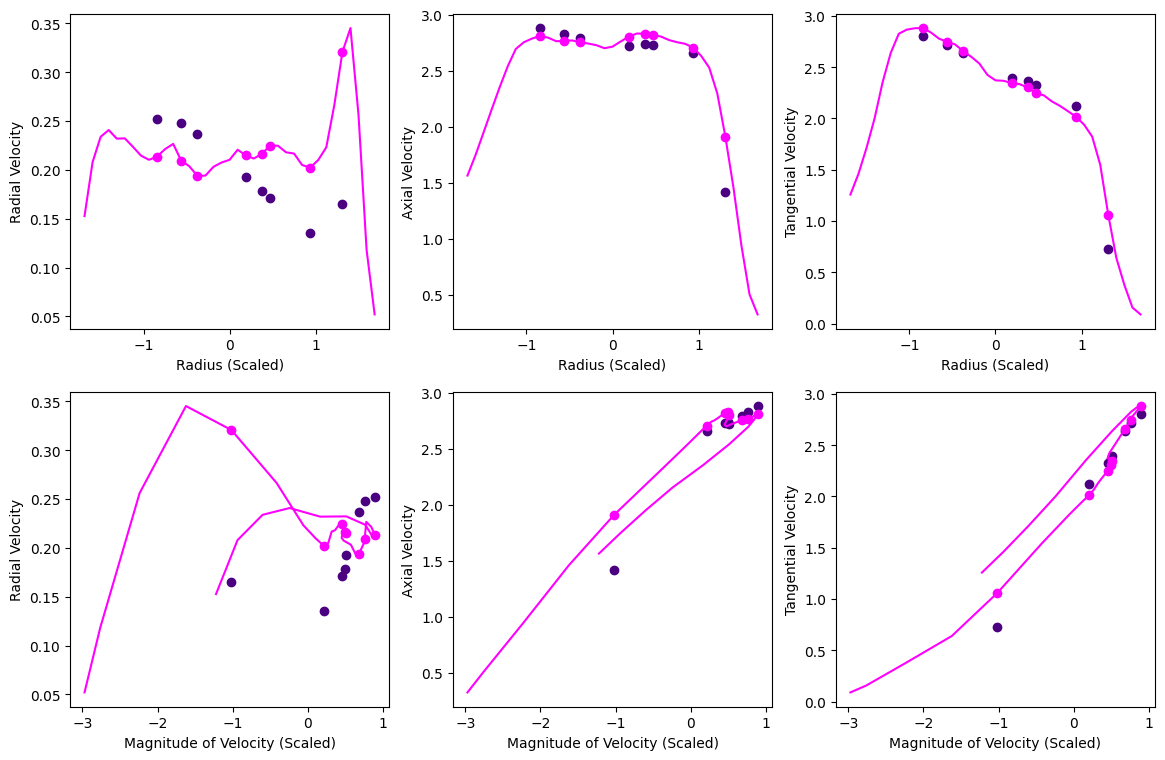

In [12]:
# Labels for the graph
LABELS = {
    "x": ["Radius", "Magnitude of Velocity"],
    "y": ["Radial Velocity", "Axial Velocity", "Tangential Velocity"]
}

# Plot a single series of y-predictions given a single series of x-values
def plot_predictions(x_idx, y_idx, ax):
    axis = ax[x_idx][y_idx]
    axis.scatter(X_test.detach().numpy()[:, x_idx], Y_preds.detach().numpy()[:, y_idx], color="indigo")
    axis.scatter(X_test.detach().numpy()[:, x_idx], Y_test.detach().numpy()[:, y_idx], color="magenta")
    axis.plot(X_scaled[:, x_idx], Y[:, y_idx], color="magenta")
    axis.set_xlabel(LABELS["x"][x_idx] + " (Scaled)")
    axis.set_ylabel(LABELS["y"][y_idx])

fig, ax = plt.subplots(2, 3, figsize=(14, 9))

# Plot all combinations of x-values and y-predictions
for i in range(2):
    for j in range(3):
        plot_predictions(i, j, ax)

The plots are 2D cross sections of the model's predictions. The pink lines represent the actual data. The pink points represent points from the actual data that were set aside for testing. The purple points are the outputs of the model from the testing data. The model is pretty good at matching the data, and the dots generally predict the unseen test data pretty well, although not perfectly.

Next, I tried running the model on *all* data (both train and test), and plotted it in 3D to see the the accuracy of the model as a whole.

In [13]:
# Turn on evaluation mode
model_1.eval()

# Make predictions on *all* input data points
with torch.inference_mode():
    Y_preds = model_1(torch.tensor(X_scaled, dtype=torch.float32))

In [14]:
# Uncomment to allow interactivity
# %matplotlib widget

# Plot a 3D chart with the x-y plane being the two inputs, and the z-axis being a single output
def plot3d(y_idx):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], Y_preds.detach().numpy()[:, y_idx], label="Predicted")
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], Y[:, y_idx], label="Actual")
    ax.set_title(f"{LABELS['y'][y_idx]} versus Radius and Magnitude of Velocity")
    plt.legend()
    plt.show()

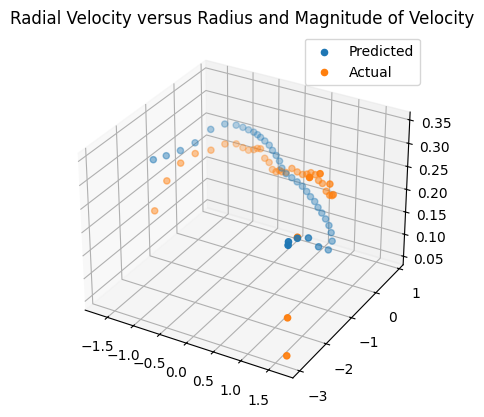

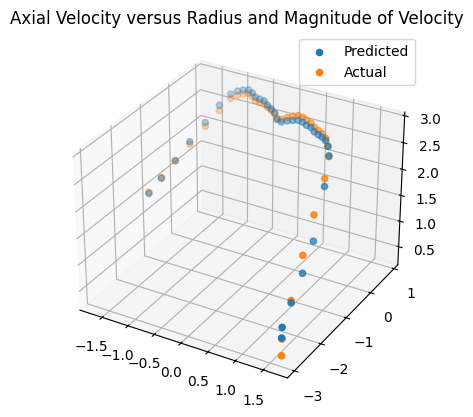

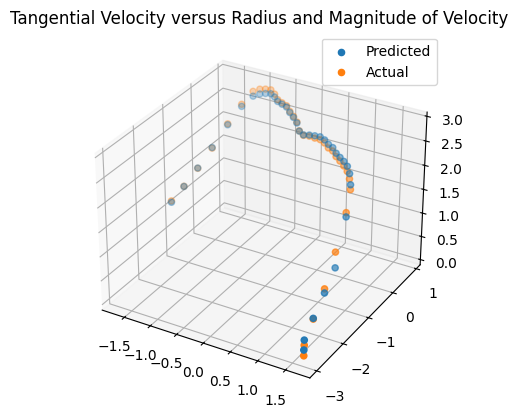

In [15]:
plot3d(0) # Radial velocity
plot3d(1) # Axial velocity
plot3d(2) # Tangential velocity

All the graphs show that the model matches train and test data well. The worst performance of the model is at predicting radial velocity on one edge of the graph: the actual data is curved upwards, while the predicted data is more of a straight line.

## Conclusion

This dataset turned out to be well-served by a simple neural network. Adjusting the learning rate was enough to drastically improve the performance of the model. Given two inputs, the model is able to predict three outputs well-enough to model the real behavior of methanol spray flame combustion. Overall, I am happy with the model and I learned how to apply neural networks to multidimensional inputs and outputs.

## Bibliography

- The paper that explains the dataset: https://doi.org/10.1016/S0010-2180(01)00374-1
- The dataset: https://webbook.nist.gov/chemistry/special/spray-combust/